Note: based on: https://github.com/arsena-k/discourse_atoms/blob/master/DATM%20Tutorial%20Part%201%20of%201%20-%20Identifying%20Atoms%20-%20for%20Public.ipynb

# Discourse Atom Topic Modeling (DATM) Tutorial 

## Part 1 of 2: Extract Atoms from Word Embedding Trained on your Text Data

* This code is written in Python 3.7.2, and uses Gensim version 3.8.3. 
* This code is provides an the outline of how we identified topics in a word embedding trained on our cleaned data, and then explored the resultings topics. Note that we cannot redistribute the data used in our paper "Integrating Topic Modeling and Word Embedding" in any form, and researchers must apply directly to the Centers for Disease Control and Prevention for access. Details on data access are provided in the paper. We add comments with tips for adapting this code to your data. 

In [1]:
from __future__ import division
import pandas as pd
import math
from gensim.models import coherencemodel
import pickle
from scipy.linalg import norm
from sklearn.preprocessing import normalize
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity
import os
from itertools import combinations
import numpy as np
from gensim import corpora, models, similarities #calc all similarities at once, from http://radimrehurek.com/gensim/tut3.html
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec, KeyedVectors
from random import seed, sample
import seaborn as sns
from ksvd import ApproximateKSVD 

from tqdm import tqdm

from quality import reconst_qual, topic_diversity, coherence_centroid, coherence_pairwise #written for this jupyter notebook

## Setup

In [29]:
# Files to import
chosen_wv_model = './models/gensim_model_window25_vector300'

# Folder to save datm files
datm_folder = './datm/'

# Output files
results_file = 'data/datm_results.csv' # datm models comparison
chosen_datm_model = './datm/325comp_5nonzeros_dictionary'
topics_file = 'data/topics.csv'

In [5]:
currentmodel = KeyedVectors.load(chosen_wv_model)

## Extract Atoms with K-SVD

In [4]:
def do_aksvd(w2vmodel, n_comp, n_nonzeros,  savelocation, save=False ):
    aksvd_t = ApproximateKSVD(n_components=n_comp, transform_n_nonzero_coefs=n_nonzeros) #n_components is number of discourse atoms, if vocab size is smallish, keep this fewer. transform_n is the number of atoms (components) that a word can be a linear combo of
    dictionary_t = aksvd_t.fit(w2vmodel.wv.vectors).components_ # Dictionary is the matrix of discourse atoms.
    gamma_t = aksvd_t.transform(w2vmodel.wv.vectors) #get the gammas, which are the "weights" of each word on a discourse atoms
    #len(dictionary[0]) #check that a discourse-atom vector is still same dimensions as word-vectors, note that norm of the dictionary vecs (atoms) are each 1! 
    if save==True:
        outfile = open(str(savelocation)  + str(n_comp) + 'comp_' + str(n_nonzeros) + 'nonzeros_aksvd','wb')
        pickle.dump(aksvd_t,outfile)
        outfile.close()
        
        outfile = open(str(savelocation)  +str(n_comp) + 'comp_' + str(n_nonzeros) + 'nonzeros_dictionary' ,'wb')
        pickle.dump(dictionary_t,outfile)
        outfile.close()
        
        outfile = open(str(savelocation)  + str(n_comp) + 'comp_' + str(n_nonzeros) + 'nonzeros_gamma','wb')
        pickle.dump(gamma_t,outfile)
        outfile.close()
    return(dictionary_t, gamma_t)


Select the number of hyperparameters (e.g., number of atoms and/or number of nonzeros) by training models on a range of these hyperparameters and using quality metrics to select the best model

In [5]:
ntopics= []
nonzeros = []
cohere_pairwise= []
div=[]
sse= []
rmse =[]
r2=[]

In [6]:
for i in tqdm([100, 125, 150, 175, 200, 225, 250, 275, 325, 375, 425,500,600]): 
    for j in [5]: # Arora and A-K both choose 5
        dictionary, gamma = do_aksvd(currentmodel, i, j, datm_folder,  save=True) #varying hyperparameters
        cohere_pairwise.append(coherence_pairwise(currentmodel, dictionary, top_n=25))
        div.append(topic_diversity(currentmodel, dictionary, top_n=25))
        rec= reconst_qual(currentmodel, dictionary, gamma)
        sse.append(rec[0])
        rmse.append(rec[1])
        r2.append(rec[2])
        ntopics.append(i)
        nonzeros.append(j)

100%|███████████████████████████████████████████████████████████████████████████████| 13/13 [1:02:05<00:00, 286.54s/it]


In [7]:
quality_results = pd.DataFrame(data={'Components_Topics': ntopics,'Nonzeros': nonzeros,
                'CohereCossim_top25_mean': cohere_pairwise, 'Diversity_top25': div, 
                  'SSE': sse,'RMSE': rmse, 'R2': r2})

In [8]:
quality_results
# 200 or 325 seems best

,Components_Topics,Nonzeros,CohereCossim_top25_mean,Diversity_top25,SSE,RMSE,R2
0,100,5,0.452228,0.992400,6.141178e+06,0.558526,0.422589
1,125,5,0.448123,0.979520,5.929789e+06,0.548830,0.442464
2,150,5,0.448306,0.977600,5.741192e+06,0.540031,0.460196
3,175,5,0.440464,0.967543,5.577016e+06,0.532254,0.475633
4,200,5,0.436243,0.962800,5.461141e+06,0.526696,0.486528
5,225,5,0.433819,0.952178,5.366558e+06,0.522115,0.495420
6,250,5,0.431903,0.941920,5.262468e+06,0.517026,0.505207
7,275,5,0.434660,0.928727,5.186565e+06,0.513284,0.512344
8,325,5,0.441767,0.900923,5.051889e+06,0.506576,0.525007
9,375,5,0.438370,0.885013,4.931244e+06,0.500491,0.536350


In [9]:
# Not done first time
quality_results.to_csv(results_file, index=False)

[(0.0, 1.0)]

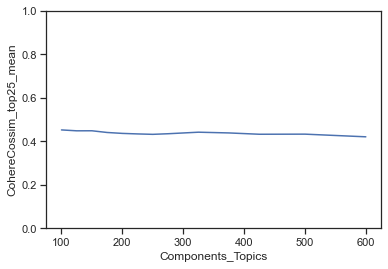

In [11]:
sns.set(style="ticks")
plt=sns.lineplot(x="Components_Topics", y="CohereCossim_top25_mean", data=quality_results, sort=True)
#plt.legend(bbox_to_anchor=(1.3, .5),loc='center right')#, borderaxespad=0.) 
plt.set(ylim=(0,1))
#plt.set(xlim=(0,550))

# Higher coherence is better; more interpretable for humans.

[(0.0, 1.0)]

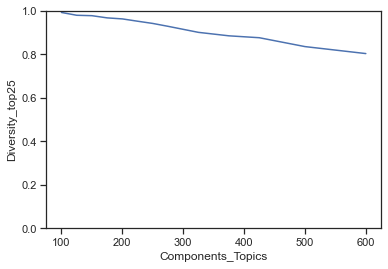

In [13]:
sns.set(style="ticks")
plt=sns.lineplot(x="Components_Topics", y="Diversity_top25", data=quality_results, sort=True)
#plt.legend(bbox_to_anchor=(1.3, .5),loc='center right')#, borderaxespad=0.) 
plt.set(ylim=(0,1))
#plt.set(xlim=(0,550))

# THe higher the value, the less overlap there is between topics. 200 or 250 topics seems best. Otherwise 400

[(0.0, 1.0)]

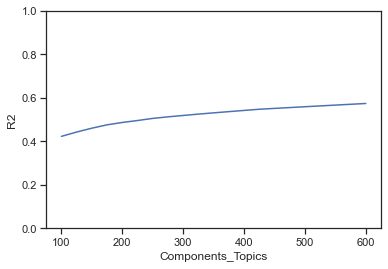

In [14]:
sns.set(style="ticks")
plt=sns.lineplot(x="Components_Topics", y="R2", data=quality_results, sort=True)
#plt.legend(bbox_to_anchor=(1.3, .5),loc='center right')#, borderaxespad=0.) 
plt.set(ylim=(0,1))


# Marginal gains seem to flatten after 275

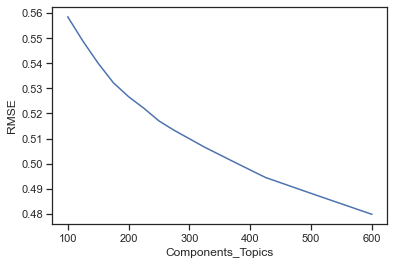

In [15]:
sns.set(style="ticks")
plt=sns.lineplot(x="Components_Topics", y="RMSE", data=quality_results, sort=True)
#plt.legend(bbox_to_anchor=(1.3, .5),loc='center right')#, borderaxespad=0.) 
#plt.set(ylim=(.67, .85))


# Again 250ish seems where marginal gains get lower

## Exploring the Model and Resulting Topics

In [3]:
with open(chosen_datm_model,'rb') as f:
    mydictionary=pickle.load(f)

Exploring the 25 most similar words to each atom atom and their respective cosine similarities (note that here is where you get a "topic": the distribution of words that characterize an atom vector

In [17]:
words = []
for i in range(0, len(mydictionary)): 
    names = [j[0] for j in currentmodel.wv.similar_by_vector(mydictionary[i],topn=25)]
    words.append(names)

In [19]:
df = pd.DataFrame({"Most_similar":words})

In [20]:
df.head()

,Most_similar
0,"[director, david_fincher, writer/director, den..."
1,"[define, reinforce, portray, represent, depict..."
2,"[7.5, rating, 6.5, 5.5, 6/10, b+, 7/10, 4.5/10..."
3,"[stark, avengers, rhodey, cap, tony, tony_star..."
4,"[fuckin, lmao, bro, lol, yo, bruh, lmfao, haha..."


In [31]:
df.to_csv(topics_file, sep=";")

#### Extract a Gender Dimension and Compute the Gender Loading of the Topics

In [19]:
manvec = np.mean([currentmodel.wv['male'],  currentmodel.wv['man'], currentmodel.wv['he'], currentmodel.wv['his'], currentmodel.wv['him'], currentmodel.wv['himself']], axis=0)
womanvec= np.mean([currentmodel.wv['female'],  currentmodel.wv['woman'], currentmodel.wv['she'], currentmodel.wv['hers'], currentmodel.wv['her'], currentmodel.wv['herself']], axis=0)

gendervec= normalize(womanvec.reshape(1, -1))-normalize(manvec.reshape(1, -1))

cossim_gender=[]
for i in range(0, len(mydictionary)):
    print("Discourse_Atom " + str(i))
    print([i for i in currentmodel.wv.similar_by_vector(mydictionary[i],topn=25)]) #what are the most similar words to the ith discourse atom?
    print()
    print(cosine_similarity(gendervec.reshape(1,-1), mydictionary[i].reshape(1,-1))[0])
    cossim_gender.append(cosine_similarity(gendervec.reshape(1,-1), mydictionary[i].reshape(1,-1))[0])
    print()

In [20]:
#look at the topics with the largest loading on this dimension (the scalar indicates strength of the loading, the sign indicates direction - whether on the feminine or masculine side)
zippes= zip( cossim_gender, [i for i in range(0, len(mydictionary))]) #get most fem/masc
sorted(zippes)

In [30]:
currentmodel.wv.most_similar(positive=['racism'], topn=25)

[('racial', 0.7111676335334778),
 ('bigotry', 0.7062075734138489),
 ('discrimination', 0.7057075500488281),
 ('homophobia', 0.6691820621490479),
 ('racist', 0.6657572388648987),
 ('sexism', 0.6615782380104065),
 ('white_supremacy', 0.6554381251335144),
 ('prejudice', 0.6517120599746704),
 ('segregation', 0.6459267735481262),
 ('black_americans', 0.6431726813316345),
 ('police_brutality', 0.6337027549743652),
 ('classism', 0.6302781105041504),
 ('oppression', 0.6274203062057495),
 ('xenophobia', 0.6266781687736511),
 ('african_americans', 0.6238213181495667),
 ('blacks', 0.6231830716133118),
 ('minorities', 0.6201534867286682),
 ('african-americans', 0.6115623116493225),
 ('black_community', 0.6067768335342407),
 ('whites', 0.6029130816459656),
 ('overt_racism', 0.6017928123474121),
 ('institutional_racism', 0.5896153450012207),
 ('misogyny', 0.5871674418449402),
 ('racists', 0.5867252349853516),
 ('race_relations', 0.5857805609703064)]

#### Extract an Indoor/Outdoor Dimension and Compute the Loading of the Topics on this Dimension

In [31]:
indoorvec = np.mean([currentmodel.wv['african_americans'],  currentmodel.wv['blm']], axis=0)
outdoorvec= np.mean([currentmodel.wv['sjws'], currentmodel.wv['leftist']], axis=0)

indooroutdoorvec= normalize(indoorvec.reshape(1, -1))-normalize(outdoorvec.reshape(1, -1))

cossim_indout=[]
for i in range(0, len(mydictionary)):
    print("Discourse_Atom " + str(i))
    print([i[0] for i in currentmodel.wv.similar_by_vector(mydictionary[i],topn=15)]) #what are the most similar words to the Nth dicourse atom?
    print(cosine_similarity(indooroutdoorvec.reshape(1,-1), mydictionary[i].reshape(1,-1))[0])
    cossim_indout.append(cosine_similarity(indooroutdoorvec.reshape(1,-1), mydictionary[i].reshape(1,-1))[0])
    #print('\n')

Discourse_Atom 0
['director', 'david_fincher', 'writer/director', 'denis_villeneuve', 'fincher', 'screenwriter', 'sheridan', 'damien_chazelle', 'steven_spielberg', 'directors', 'directing', 'cinematographer', 'filmmaker', 'brad_bird', 'producer']
[-0.03193679]
Discourse_Atom 1
['define', 'reinforce', 'portray', 'represent', 'depict', 'illustrate', 'demonstrate', 'expose', 'conform', 'convey', 'achieve', 'downplay', 'emphasize', 'dictate', 'validate']
[0.07487357]
Discourse_Atom 2
['7.5', 'rating', '6.5', '5.5', '6/10', 'b+', '7/10', '4.5/10', '3/10', 'b-', '6.5.', 'c-', '3/5', '7.5.', '2/5']
[0.00597573]
Discourse_Atom 3
['stark', 'avengers', 'rhodey', 'cap', 'tony', 'tony_stark', 'hawkeye', 'ironman', 'war_machine', 'civil_war', 'captain_america', 'rhodes', 'iron_man', 'antman', 'winter_solider']
[0.09404641]
Discourse_Atom 4
['fuckin', 'lmao', 'bro', 'lol', 'yo', 'bruh', 'lmfao', 'hahahaha', 'omg', 'hahaha', 'oh', 'nvm', 'xd', 'ohh', 'brah']
[-0.25351325]
Discourse_Atom 5
['girl', 'l

[-0.08265487]
Discourse_Atom 73
['carried_away', 'riled_up', 'tiring', 'misty_eyed', 'ball_rolling', 'my_nerves', 'antsy', 'tiresome', 'choked_up', 'restless', 'hands_dirty', 'flack', 'dizzy', 'teary-eyed', 'teary_eyed']
[-0.07415404]
Discourse_Atom 74
['k', 'joi', 'deckard', 'rachael', 'roy_batty', '2049.', 'replicant', '2049', 'sapper_morton', 'k/joe', 'k.', 'blade_runner', 'wallace', 'luv', 'replicants']
[0.01947923]
Discourse_Atom 75
['enjoy', 'pay_attention', 'watch', 'pick_apart', 'dissect', 'digest', 'recommend', 'sit_through', 'spoil', 'analyze', 'pick_up', 'appreciate', 'see', 'revisit', 'follow_along']
[-0.0624121]
Discourse_Atom 76
['tlj', 'tfa', 'last_jedi', 'episode_7', 'ros', 'tros', 'episode_8', 'ep_7', 'rian', 'jj', 'force_awakens', 'rian_johnson', 'sequel_trilogy', 'ot', 'abrams']
[-0.19927004]
Discourse_Atom 77
['vanished', 'revived', 'brought_back', 'returned', 'disappeared', 'restored', 'come_back', 'erased', 'gone_forever', 'resurrected', 'disintegrated', 'coming_b

[-0.06921151]
Discourse_Atom 115
['pennywise', 'bowers', 'henry_bowers', 'bev', 'richie', 'beverly', 'georgie', 'mike', 'losers_club', 'derry', 'deadlights', 'chapter_1', 'stan', 'losers', 'book']
[0.10183872]
Discourse_Atom 116
['recognize', 'relate', 'tell', 'understand', 'see', 'say', 'tolerate', 'criticize', 'offend', 'recognise', 'accept', 'argue', 'dismiss', 'acknowledge', 'confuse']
[-0.08960821]
Discourse_Atom 117
['smiling', 'face', 'screaming', 'closeup', 'crotch', 'stare', 'lips', 'silently', 'staring', 'smile', 'stares', 'doorway', 'hunched_over', 'flailing', 'standing']
[-0.10437599]
Discourse_Atom 118
['these_days', 'nowadays', 'produces', 'tentpole', 'entertainment', 'consumer', 'mainstream', 'indie', 'typically', 'cinephiles', 'usually', 'action/superhero', 'arthouse', 'caters', 'art-house']
[-0.13888801]
Discourse_Atom 119
['felt', 'seemed', 'seems', 'looks', 'feels', 'looked', 'came_across', 'sounded', 'feel', 'sounding', '*felt*', 'comes_across', 'seem', 'acted', 'so

Discourse_Atom 157
['spider-man', 'spidey', 'spiderman', 'spider_man', 'green_goblin', 'doc_ock', 'tobeys', 'peter_parker', 'doc_oc', 'parker', 'octavius', 'osborn', 'otto', 'tobey_maguire', 'holland']
[0.10501847]
Discourse_Atom 158
['sersi', 'thena', 'ikaris', 'druig', 'ajak', 'ikarus', 'sprite', 'gilgamesh', 'kingo', 'makkari', 'phastos', 'deviants', 'deviant', 'sersei', 'eternals']
[0.03921549]
Discourse_Atom 159
['lena', 'shimmer', 'kane', 'area_x', 'ventress', 'self_destruction', 'self-destruction', 'lighthouse', 'lenas', 'refraction', 'josie', 'portman', 'area-x', 'biologist', 'refracting']
[0.00752443]
Discourse_Atom 160
['diana', 'cheetah', 'maxwell_lord', 'max_lord', 'barbara', 'ww', 'lasso', 'maxwell', 'steve_trevor', 'dreamstone', 'trevor', 'invisible_jet', 'dianna', 'chris_pine', 'monkey_paw']
[-0.0250898]
Discourse_Atom 161
['viewer', 'audience', 'viewers', 'audiences', 'spike_lee', 'subject_matter', 'general_audience', 'aronofsky', 'pta', 'filmmakers', 'qt', 'tarantino',

[0.09775593]
Discourse_Atom 196
['merchandise', 'merch', 'plush', 'hasbro', 'mercedes', 'coca_cola', 'doritos', 'toys', 'plushies', 'commercial', 'microsoft', 'toy', 'sponsors', 'lexus', 'sponsorship']
[-0.11742569]
Discourse_Atom 197
['colonel', 'caesar', 'fitzgerald', 'koba', 'ceaser', 'agu', 'ceasar', 'renner', 'caeser', 'liam', 'conrad', 'whitaker', 'schofield', 'cesar', 'fitz']
[0.21106858]
Discourse_Atom 198
['unless', 'since', 'assuming', 'implying', 'because', 'when', 'hence_why', 'if', 'even_though', 'until', 'where', 'especially_since', 'iirc', 'pretty_sure', 'before']
[0.08996316]
Discourse_Atom 199
['cruelty', 'resentment', 'selfishness', 'apathy', 'hatred', 'rejection', 'compassion', 'greed', 'acceptance', 'insecurity', 'loneliness', 'corruption', 'indifference', 'despair', 'bitterness']
[0.10501496]
Discourse_Atom 200
['movies', 'films', 'blockbusters', 'superhero_movies', 'flicks', 'superhero_films', 'comedies', 'marvel_movies', 'animated_films', 'franchises', 'productio

[-0.24106344]
Discourse_Atom 236
['instances', 'ones', 'incidents', 'characters', 'cast_members', 'minor_quibbles', 'instances_where', 'segments', 'facets', 'things', 'minor_complaints', 'minor_gripes', 'tidbits', 'outliers', 'stories']
[0.07878711]
Discourse_Atom 237
['dynamic_between', 'relationship_between', 'conflict_between', 'tension_between', 'friendship_between', 'chemistry_between', 'interaction_between', 'dynamic', 'romance_between', 'interactions_between', 'chemistry', 'connection_between', 'banter_between', 'confrontation_between', 'relationships_between']
[0.20585057]
Discourse_Atom 238
['space_stone', 'stones', 'mind_stone', 'infinity_stones', 'gauntlet', 'power_stone', 'stone', 'reality_stone', 'tesseract', 'soul_stone', 'glove', 'gem', 'infinity_stone', 'infinity_gauntlet', 'pym_particle']
[-0.00625958]
Discourse_Atom 239
['arguments', 'public_opinion', 'argument', 'discourse', 'debate', 'disagreement', 'seale', 'statement', 'bergoglio', 'accusations', 'policies', 'admi

[0.10381704]
Discourse_Atom 275
['scares', 'jump_scare', 'horror', 'jumpscare', 'scary', 'jumpscares', 'jump_scares', 'babadook', 'spooky', 'conjuring_2', 'psychological_horror', 'scare', 'unsettling', 'exorcist', 'vvitch']
[0.04321908]
Discourse_Atom 276
['plot_points', 'missteps', 'missed_opportunities', 'elements', 'minor_issues', 'moments', 'glaring_problems', 'parts', 'aspects', 'conveniences', 'plot_holes', 'minor_quibbles', 'minor_gripes', 'subplots', 'plot_twists']
[0.05631959]
Discourse_Atom 277
['louise', 'heptapods', 'heptapod', 'non-linear', 'heptapod_language', 'non-linear_time', 'dr._banks', 'universal_language', 'chinese_general', 'non-linearly', 'alien_language', 'linearly', 'linear', 'nonlinear', 'perceive_time']
[0.04510309]
Discourse_Atom 278
['poorly_done', 'clunky', 'underwhelming', 'unfocused', 'sloppy', 'lackluster', 'contrived', 'weak', 'uninspired', 'undercooked', 'bland', 'uninteresting', 'underdeveloped', 'unmemorable', 'disjointed']
[-0.08685251]
Discourse_A

[-0.00962906]
Discourse_Atom 314
['taking_place', 'occurs', 'took_place', 'take_place', 'occurring', 'occurred', 'takes_place', 'happened', 'occur', 'happening', 'occured', 'unfolding', 'events', 'transpired', 'event']
[0.12237666]
Discourse_Atom 315
['ransom', 'blanc', 'marta', 'fran', 'harlan', 'cecilia', 'ruth', 'adrian', 'sheriff', 'warren', 'hangman', 'cops', 'toxicology_report', 'zeke', 'marquis']
[0.12965334]
Discourse_Atom 316
['fathom_how', 'pinpoint', 'fathom', 'be_argued', 'unsee', 'discern', 'comprehend', 'stop_smiling', 'stop_thinking', 'stop_giggling', 'resist', 'someone_eli5', 'handle', 'contain_myself', 'somebody_explain']
[0.01749238]
Discourse_Atom 317
['associated', 'interacting', 'whats_wrong', 'associating', 'paired', 'interacts', 'toyed', 'tampered', 'affiliated', 'aligned', 'empathized', 'interacted', 'toying', 'rife', 'aligns']
[0.02300485]
Discourse_Atom 318
['creates', 'gives', 'becomes', 'is', 'embraces', 'destroys', 'uses', 'accepts', 'brings', 'acknowledges

In [32]:
#look at the topics with the largest loading on this dimension (the scalar indicates strength of the loading, the sign indicates direction - whether indoor or outdoor)
zippes= zip( cossim_indout, [i for i in range(0, len(mydictionary))]) 
sorted(zippes)

[(array([-0.33924107]), 68),
 (array([-0.3074274]), 322),
 (array([-0.30532004]), 60),
 (array([-0.27810506]), 320),
 (array([-0.25351325]), 4),
 (array([-0.24425372]), 268),
 (array([-0.24106344]), 235),
 (array([-0.2312923]), 102),
 (array([-0.22620519]), 271),
 (array([-0.21389134]), 270),
 (array([-0.21386486]), 217),
 (array([-0.19927004]), 76),
 (array([-0.19622823]), 181),
 (array([-0.19056187]), 9),
 (array([-0.18995489]), 300),
 (array([-0.18638675]), 55),
 (array([-0.171046]), 211),
 (array([-0.16179801]), 264),
 (array([-0.1591094]), 133),
 (array([-0.15433058]), 153),
 (array([-0.1524607]), 143),
 (array([-0.15037188]), 269),
 (array([-0.14252438]), 246),
 (array([-0.13888801]), 118),
 (array([-0.1386109]), 292),
 (array([-0.13536586]), 87),
 (array([-0.13257924]), 145),
 (array([-0.12261626]), 146),
 (array([-0.11742569]), 196),
 (array([-0.11370903]), 194),
 (array([-0.11350157]), 137),
 (array([-0.10829831]), 306),
 (array([-0.10801791]), 32),
 (array([-0.10585941]), 58)

In [36]:
for i in range(len(mydictionary)): 
    print("Discourse_Atom " + str(i))
    print([j[0] for j in currentmodel.wv.similar_by_vector(mydictionary[i],topn=25)]) #what are the 25 most similar words to the Nth dicourse atom?
    print('\n')

Discourse_Atom 0
['suffering', 'severe', 'trauma', 'catastrophic', 'consequences', 'loss', 'crippling', 'debilitating', 'traumatic', 'starvation', 'brain_damage', 'withdrawal', 'illnesses', 'untreated', 'ptsd', 'illness', 'injuries', 'repercussions', 'suffer', 'endured', 'hardship', 'symptoms', 'pain', 'hardships', 'famine']


Discourse_Atom 1
['blown_away', 'floored', 'intrigued', 'enthralled', 'underwhelmed', 'impressed', 'mesmerized', 'taken_aback', 'captivated', 'perplexed', 'saddened', 'unimpressed', 'wowed', 'disappointed', 'fascinated', 'stunned', 'amused', 'annoyed', 'entranced', 'astounded', 'let_down', 'creeped_out', 'irked', 'amazed', 'irritated']


Discourse_Atom 2
['wikipedia', 'website', 'wikipedia_page', 'wiki_page', 'wiki', 'wikipedia_article', 'front_page', 'fb', 'google', 'imdb', 'site', 'yt', 'page', 'tv_tropes', 'youtube', 'imdb_page', 'blog', 'article', 'wookiepedia', 'twitter', 'article_https', 'youtube_channel', 'imbd', 'facebook', 'letterboxd']


Discourse_Atom 

['you', "you_'re", 'yourself', 'your', 'your_argument', 'your_opinion', '*you*', 'rebuttal', 'ad_hominem', 'youre', 'strawman', 'yours', 'counter_argument', 'your_comment', 'reading_comprehension', 'personal_insults', 'constructive_criticism', 'yourselves', 'post_history', 'fallacy', 'semantics', 'your_username', 'your_brain', 'pedantic', 'downvotes']


Discourse_Atom 46
['cater', 'pander', 'alienate', 'appease', 'piss_off', 'appeal', 'confuse', 'satisfy', 'annoy', 'appeals', 'offend', 'remind', 'endear', 'placate', 'reassure', 'entertain', 'attract', 'catering', 'spoon_feed', 'appealed', 'impress', 'recognize', 'belittle', 'tell', 'relate']


Discourse_Atom 47
['iirc', 'including', 'via', 'presumably', 'mentions', 'etc', 'hence', 'according', 'specifically', 'apparently', 'specifically_mentioned', 'includes', 'etc.', 'afaik', 'additionally', 'various', 'most_notably', 'aka', 'supposedly', 'states', 'shortly_before', 'involving', 'containing', 'i.e', 'which_includes']


Discourse_Atom 

['achieving', 'achieve', 'goals', 'fulfilling', 'achieved', 'goal', 'accomplishing', 'success', 'fulfilled', 'aspirations', 'ambitions', 'succeed', 'fulfill', 'fulfillment', 'pursue', 'accomplished', 'succeeding', 'achieves', 'accomplish', 'ambition', 'desires', 'pursuing', 'attain', 'ultimately', 'greatness']


Discourse_Atom 93
['alarm_went', 'pisses', 'goofing', 'rocker', 'pisses_me', 'tapered', 'jerking', 'proper_send', 'shrugs', 'head_chopped', 'shrugged', 'arm_bitten', 'hand_chopped', 'trailed', 'piggy_back', 'charts', 'brushes', 'lop', 'unceremoniously_killed', 'auctioning', 'brushed', 'rattles', 'piggybacking', 'shrug', 'grid']


Discourse_Atom 94
['answer', 'answers', 'answered', 'answering', 'ask', 'clarification', 'explanation', 'explanations', 'questions', 'definitive_answer', 'question', 'asking', 'reply', 'rhetorical', 'asked', 'questions_regarding', 'discussion', 'insight', 'detailed_explanation', 'reddit_thread', 'left_unanswered', 'rebuttal', 'explaination', 'clarifyin

['dead_bodies', 'rifles', 'buildings', 'balloons', 'helicopters', 'bags', 'dudes', 'trucks', 'humvees', 'corpses', 'spears', 'armed_guards', 'machine_guns', 'tents', 'tanks', 'knives', 'grenades', 'bodies', 'airplanes', 'vehicles', 'guns', 'suvs', 'plates', 'helmets', 'cans']


Discourse_Atom 145
['battle', 'fight', 'fighting', 'battles', 'fights', 'final_battle', '1v1', 'final_fight', 'vs', 'one-on-one', 'fight_against', 'armies', 'fought', 'v.', 'battling', '2v1', 'v', 'arena', 'brawl', 'duel', 'vs.', 'clash', 'fist_fight', 'duels', 'showdown']


Discourse_Atom 146
['emotional_investment', 'prior_knowledge', 'interest', 'emotional_attachment', 'self-awareness', 'control_over', 'emotional_connection', 'emotional_weight', 'relevance', 'redeeming_qualities', 'self_awareness', 'substance', 'qualms_about', 'attachment', 'awareness', 'knowledge', 'input', 'redeemable_qualities', 'incentive', 'formal_training', 'repercussions', 'emotional_impact', 'consequence', 'insight', 'training_whatsoe

['lion_king', 'hakuna_matata', 'pumba', 'timon', 'zazu', 'pumbaa', 'nala', 'beyonce', 'simba', 'timone', 'hunchback', 'young_simba', 'broadway_version', 'hyenas', 'aladdin', 'rafiki', 'animated_version', 'mufasa', 'notre_dame', 'jungle_book', 'little_mermaid', 'beyonce_song', 'musical', 'songs', 'frozen_2']


Discourse_Atom 198
['mockingjay_part', 'gotg_vol', 'bad_boys', 'annabelle', 'super_troopers', 'toy_story', 'sequels', 'httyd', 'conjuring_1', 'conjuring', 'daredevil_season', 'trilogies', 'space_jam', '2', 'guardians_vol', '3', 'despicable_me', '1/2_hours', 'insidious', 'zombieland', 'amazing_spider-man', 'jurassic_world', '1', 'incredibles', 'amazing_spiderman']


Discourse_Atom 199
['easter_eggs', 'little_details', 'small_details', 'plot_points', 'tidbits', 'plot_twists', 'details', 'references', 'tiny_details', 'callbacks', 'elements', 'call_backs', 'plot_holes', 'inconsistencies', 'subtle_hints', 'throwbacks', 'setups', 'twists', 'nods', 'allusions', 'metaphors', 'nuances', 'r

['stones', 'pym_particles', 'pym_particle', 'infinity_stones', 'soul_stone', 'stone', 'nebula', 'particles', '2014_nebula', 'space_stone', 'past_nebula', 'gauntlet', 'mind_stone', 'snap', 'thanos', 'soulstone', 'main_timeline', 'reality_stone', 'timestone', 'timeline', 'tessaract', 'vial', 'original_timeline', 'tesseract', 'prime_timeline']


Discourse_Atom 242
['beliefs', 'worldview', 'intentions', 'views', 'perception', 'interpretation', 'viewpoint', 'biases', 'perceptions', 'political_beliefs', 'political_views', 'assessment', 'actions', 'personal_feelings', 'convictions', 'preferences', 'sympathies', 'feelings_towards', 'judgment', 'subjective_opinion', 'notions', 'opinions', 'skepticism', 'judgement', 'upbringing']


Discourse_Atom 243
['destroy', 'locate', 'subdue', 'summon', 'wipe_out', 'extract', 'annihilate', 'kill', 'activate', 'contain', 'eliminate', 'disable', 'disarm', 'retrieve', 'infiltrate', 'acquire', 'detect', 'rebuild', 'send', 'replicate', 'overpower', 'create', 'de

['while_simultaneously', 'ends_up', 'constantly', 'whilst', 'instead', 'rather_than', 'keeps', 'without', 'ended_up', 'too_busy', 'while', 'despite', 'found_myself', 'stop', 'please_stop', 'involves', 'spends', 'tricked_into', 'winds_up', 'incapable', 'as_opposed', 'find_myself', 'thereby', 'kept', 'avoid']


Discourse_Atom 281
['happend', 'amounted', 'else', 'doing', 'matters', 'accomplished', 'mattered', 'happened', 'happening', 'transpired', 'no_matter', 'entails', 'bothers_me', 'hunky_dory', 'happens', 'accomplishes', 'accomplish', 'confuses_me', 'theyve_done', 'pretty_much', 'achieved', 'accomplishing', '*happened*', 'is..', 'done']


Discourse_Atom 282
['60s', '1980s', '70s', '50s', '1960s', 'early_90s', '90s', '1970s', 'early_2000s', "'80s", '1950s', 'late_90s', '2000s', '80s', "'90s", '1990s', '1980', 'late_80s', 'era', 'eighties', 'modern_day', '40s', '1960', 'late_60s', 'late_70s']


Discourse_Atom 283
['tears', 'joy', 'teared_up', 'joyful', 'sadness', 'bittersweet', 'heartbr

['edith', 'illusions', 'beck', 'illusion', 'mysterio', 'real', 'recordings', 'mysterios', 'quentin_beck', 'elementals', 'tangible', 'holograms', 'deception', 'liz', 'fake', 'pym', 'illusionist', 'stark_employee', 'eichmann', 'killian', 'kingsley', 'stark_industries', 'toomes', "o'neal", 'holographic']


Discourse_Atom 330
['box_office', 'flop', 'box-office', 'domestically', 'ticket_sales', 'commercially', 'opening_weekend', 'revenue', 'sales', 'grosses', 'critical_reception', 'studios', 'success', 'financial_success', 'million_worldwide', 'boxoffice', 'underperformed', 'critical_acclaim', 'underperforming', 'flops', 'paramount', 'critical_success', 'financially', 'popularity', 'wide_release']


Discourse_Atom 331
['global', 'corporations', 'governments', 'politicians', 'economic', 'immigration', 'globally', 'healthcare', 'health_care', 'economy', 'government', 'institutions', 'policies', 'u.s.', 'climate', 'administration', 'socialist', 'unrest', 'federal_government', 'companies', 'agr

['ancient', 'temple', 'artifacts', 'tomb', 'temples', 'wayfinder', 'treasure', 'inhabitants', 'aztec', 'ancestor', 'holocrons', 'crystal', 'statues', 'agamemnon', 'artifact', 'paradise', 'jedi_temple', 'garden', 'korriban', 'shrine', 'holocron', 'serpent', 'deity', 'eden', 'descendants']


Discourse_Atom 383
['siding', 'whats_wrong', 'empathized', 'aligns', 'toyed', 'associating', 'toying', 'empathizing', 'align', 'sympathized', 'agreeing', 'disagreeing', 'dealing', 'disagreed', 'sided', 'sympathizing', 'sympathise', 'associated', 'disagrees', 'tampered', 'coupled', 'interacts', 'aligned', 'empathise', 'deal']


Discourse_Atom 384
['least_partially', 'first_glance', 'various_points', 'juncture', 'scoff', 'poke_fun', 'behest', 'poked_fun', 'certain_points', 'their_disposal', 'its_finest', 'least', 'poking_fun', 'pokes_fun', 'several_points', 'glanced', '*looks', 'marveling', 'breakneck_speed', 'gawk', 'gunpoint', 'gun_pointed', 'expense', 'dinner_table', 'lowest_point']


Discourse_Atom

['female', 'male', 'females', 'female_characters', 'female_leads', 'women', 'female_lead', 'strong_female', 'heroines', 'female_empowerment', 'female_superheroes', 'girl_power', 'feminist', 'feminism', 'empowerment', 'female_protagonist', 'empowering', 'male_leads', 'role_models', 'sexist', 'males', 'male_lead', 'female_led', 'female_heroes', 'white_male']


Discourse_Atom 435
['toys', 'bo_peep', 'toy', 'forky', 'woody', 'gabby_gabby', 'bonnie', 'bo', 'gabby', 'buzz_lightyear', 'andy', 'ts2', 'antique_shop', 'ts1', 'toy_story', 'ts4', 'antique_store', 'buzz', 'ts3', 'voice_box', 'ducky', 'woodys', 'lotso', 'andys', 'plush']


Discourse_Atom 436
['somewhere_along', 'paves', 'rubbed_me', 'any_meaningful', 'rubs_me', 'pave', 'subverted', 'too_convenient', 'cooler_than', 'every_conceivable', 'too_on-the-nose', 'paving', 'unfolds', 'exact_same', 'paved', 'too_many', 'lessened', 'subvert', 'oversold', 'overplayed', 'overused', '*every*', 'telegraphed', 'unfolded', 'theres_no']


Discourse_At

['someone_else', 'someone', 'something', 'somebody', 'somewhere_else', 'somewhere', 'somebody_else', 'elsewhere', 'sth', 'whomever', 'whatever', 'whoever', 'smth', 'he/she', 'another_commenter', 'somthing', 'w/e', 'noone', '*something*', 'some_sort', 'prostitute', 'deleted_scene', 'anybody', 'another', 'deckard']


Discourse_Atom 483
['sees', 'finds', 'confronts', 'finds_out', 'discovers', 'enters', 'wakes_up', 'realises', 'meets', 'comes_back', 'freaks_out', 'dies', 'picks_up', 'hears', 'arrives', 'runs_away', 'joins', 'notices', 'realizes', 'talks', 'escapes', 'gets', 'starts', 'rescues', 'learns']


Discourse_Atom 484
['tension_between', 'dynamic_between', 'parallels_between', 'between', 'relationship_between', 'friendship_between', 'conflict_between', 'interaction_between', 'connection_between', 'respectively', 'similarities_between', 'shared', 'conversation_between', 'interactions_between', 'confrontation_between', 'banter_between', 'both', 'exchange_between', 'differences_between

['myself', 'pause', 'pee', 'loudly', 'my_girlfriend', 'my_gf', 'bathroom', 'restroom', 'my_fiance', 'my_stomach', 'my_wife', 'my_friend', 'paused', 'panic_attack', 'living_room', 'sobbing', 'me', 'anxious', 'afterwards', 'my_brain', 'silently', 'credits_rolled', 'my_ears', 'falling_asleep', 'audibly']


Discourse_Atom 530
['cooper', 'coop', 'mann', 'armstrong', 'mcbride', 'watney', 'mcconaughey', 'romilly', 'dr._mann', 'neil_armstrong', 'mars', 'roy', 'tars', 'clooney', 'astronauts', 'interstellar', 'professor_brand', 'apollo_11', 'neptune', 'pitt', 'endurance', 'murphy', 'apollo', 'murph', 'astronaut']


Discourse_Atom 531
['reminiscent', 'very_reminiscent', 'kind', 'reminds_me', 'sort', 'reminded_me', 'course', 'reminded', 'epitome', 'type', 'reeked', 'sorts', 'got_rid', 'pinnacle', 'reeks', 'perfect_mix', 'mixture', 'big_fan', 'embodiment', 'took_advantage', 'remind_me', 'fond', 'vein', 'perfect_blend', 'perfect_example']


Discourse_Atom 532
['situation', 'scenario', 'loop', 'cheat

['dino', 't-rex', 'raptor', 't_rex', 'indoraptor', 'dinosaur', 'dinosaurs', 'trex', 'indominus_rex', 'raptors', 'i-rex', 'dinos', 'indominus', 'velociraptor', 'rex', 'spinosaurus', 'velociraptors', 'rexy', 'jp3', 'volcano', 'ingen', 'maisie', 'indo', 'carnotaurus', 'jurassic_park']


Discourse_Atom 579
['chamber', 'closet', 'basement', 'locker', 'room', 'bunker', 'jail_cell', 'container', 'compartment', 'bedroom', 'cave', 'refrigerator', 'box', 'freezer', 'cupboard', 'garage', 'house', 'lab', 'suitcase', 'tunnel', 'vault', 'facility', 'barn', 'kitchen', 'hotel_room']


Discourse_Atom 580
['stupid', 'idiotic', 'nonsensical', 'dumb', 'retarded', 'laughable', 'ridiculous', 'poorly_written', 'moronic', 'pointless', 'nonsense', 'badly_written', 'terribly_written', 'laughably', 'stupidity', 'useless', 'illogical', 'terrible', 'horribly_written', 'bullshit', 'awful', 'cringeworthy', 'braindead', 'shitty_writing', 'horrible']


Discourse_Atom 581
['satire', 'satirical', 'subversive', 'social_c

In [ ]:
# 200 topics: 7 rape + sexism, 10 sexy + feminist, 30 whining, 197 society + racism
# 325 topics: 54 racists, 68 sjw + racist, 228 african_americans + racism, 268 misogynist+sexist, 217 feminist
# 600: 9 sexism, 134 racism sexism, 434 male sexist, 460 butthurt downvoting, 300 weirdo racist